In [98]:
import json
import base64
import hashlib
from urllib.parse import urlparse
from base64 import b64encode
from haralyzer import HarParser
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from matplotlib.patches import Patch



In [99]:


dbConnect = sqlite3.connect('third_party_analysis.db')
dbCursor = dbConnect.cursor()

dbCursor.execute('''
    CREATE TABLE IF NOT EXISTS EmailHashes (
        id INTEGER PRIMARY KEY,
        host TEXT NOT NULL,
        hashType TEXT NOT NULL,
        domain TEXT NOT NULL,
        Location TEXT NOT NULL
    )
''')

newsHosts = ["zeit.de", "cnn.com", "faz.net", "merkur.de", "n-tv.de", "sueddeutsche.de", "telegraph.co.uk", "theguardian.com", "thehindu.com", "zeit.de"]
shopsHosts = ["amazon.de", "depot-online.de", "douglas.de", "hm.com", "nike.com", "samsung.com", "saturn.de", "sephora.de", "uniqlo.com", "zalando.de"]
other = ["zalando.com", "nikecloud.com", "user.id" "depot."]

email = 'yannick.nastja@gmail.com'

def isElementSubstringOfX(array, x):
    for element in array:
        if element in x:
            return True
    return False

def contains_md5(host, text, domain, location):
    hashed_email = hashlib.md5(email.encode()).hexdigest()
    if hashed_email in text:
        dbCursor.execute("INSERT INTO EmailHashes (Host, HashType, Domain, Location) VALUES (?, ?, ?, ?)", (host, 'MD5', domain, location))

def contains_base64(host, text, domain, location):
    encoded_email = base64.b64encode(email.encode()).decode()
    if encoded_email in text:
        dbCursor.execute("INSERT INTO EmailHashes (Host, HashType, Domain, Location) VALUES (?, ?, ?, ?)", (host, 'base64', domain, location))

def contains_sha256(host, text, domain, location):
    hashed_email = hashlib.sha256(email.encode()).hexdigest()
    if hashed_email in text:
        dbCursor.execute("INSERT INTO EmailHashes (Host, HashType, Domain, Location) VALUES (?, ?, ?, ?)", (host, 'SHA256', domain, location))

def contains_sha1(host, text, domain, location):
    hashed_email = hashlib.sha1(email.encode()).hexdigest()
    if hashed_email in text:
        dbCursor.execute("INSERT INTO EmailHashes (Host, HashType, Domain, Location) VALUES (?, ?, ?, ?)", (host, 'SHA1', domain, location))

def contains_sha224(host, text, domain, location):
    hashed_email = hashlib.sha224(email.encode()).hexdigest()
    if hashed_email in text:
        dbCursor.execute("INSERT INTO EmailHashes (Host, HashType, Domain, Location) VALUES (?, ?, ?, ?)", (host, 'SHA224', domain, location))

def contains_sha3_512(host, text, domain, location):
    hashed_email = hashlib.sha3_512(email.encode()).hexdigest()
    if hashed_email in text:
        dbCursor.execute("INSERT INTO EmailHashes (Host, HashType, Domain, Location) VALUES (?, ?, ?, ?)", (host, 'SHA512', domain, location))

def contains_mail(host, text, domain, location):
    if email in text:
        dbCursor.execute("INSERT INTO EmailHashes (Host, HashType, Domain, Location) VALUES (?, ?, ?, ?)", (host, 'plain', domain, location))

def findMail(entries, host):
    for entry in entries:
        request = entry.get('request', {})
        response = entry.get('response', {})
        domain = urlparse(request.get('url', '')).hostname

        for text in [request.get('url', ''), str(request.get('headers', '')), str(request.get('postData', ''))]:
            if not isElementSubstringOfX(newsHosts, domain) and not isElementSubstringOfX(shopsHosts, domain) and not isElementSubstringOfX(other, domain):
                contains_md5(host, text, domain, "REQUEST")
                contains_base64(host, text, domain, "REQUEST")
                contains_sha256(host ,text, domain, "REQUEST")
                contains_mail(host ,text, domain, "REQUEST")
                contains_sha1(host, text, domain, "REQUEST")
                contains_sha224(host,text, domain, "REQUEST")
                contains_sha3_512(host, text, domain, "REQUEST")

        for text in [str(response.get('content', {}).get('text', ''))]:
            if not isElementSubstringOfX(newsHosts, domain) and not isElementSubstringOfX(shopsHosts, domain) and not isElementSubstringOfX(other, domain):
                contains_md5(host,text, domain, "RESPONSE")
                contains_base64(host,text, domain, "RESPONSE")
                contains_sha256(host,text, domain, "RESPONSE")
                contains_mail(host,text, domain, "RESPONSE")
                contains_sha1(host, text, domain, "RESPONSE")
                contains_sha224(host, text, domain, "RESPONSE")
                contains_sha3_512(host, text, domain, "RESPONSE")

In [100]:
newsTypes = ["news/desktop/www.", "news/mobile/m."]
shopsTypes = ["shops/desktop/www.", "shops/mobile/m."]

def execute():
    for host in newsHosts:
        for type in newsTypes:
            path = "../archives/" + type + host + ".har"

            # Read the content of the HAR file and convert it to a dictionary
            with open(path, "r", encoding="utf-8") as har_file:
                harData = json.load(har_file)

            parser = HarParser(harData)
            entries = parser.har_data['entries']

            findMail(entries, host)

    for host in shopsHosts:
        for type in shopsTypes:
            path = "../archives/" + type + host + ".har"

            # Read the content of the HAR file and convert it to a dictionary
            with open(path, "r", encoding="utf-8") as har_file:
                harData = json.load(har_file)

            parser = HarParser(harData)
            entries = parser.har_data['entries']

            findMail(entries, host)
    
    dbConnect.commit()

execute()
dbCursor.close()

### Most Received email adresses

In [124]:
dbConnect = sqlite3.connect('third_party_analysis.db')
dbCursor = dbConnect.cursor()

query = "SELECT domain, COUNT(*), hashType FROM EmailHashes GROUP BY domain ORDER BY COUNT(*) DESC"
dbCursor.execute(query)
results = dbCursor.fetchall()

dbConnect.close()

**Visualization**

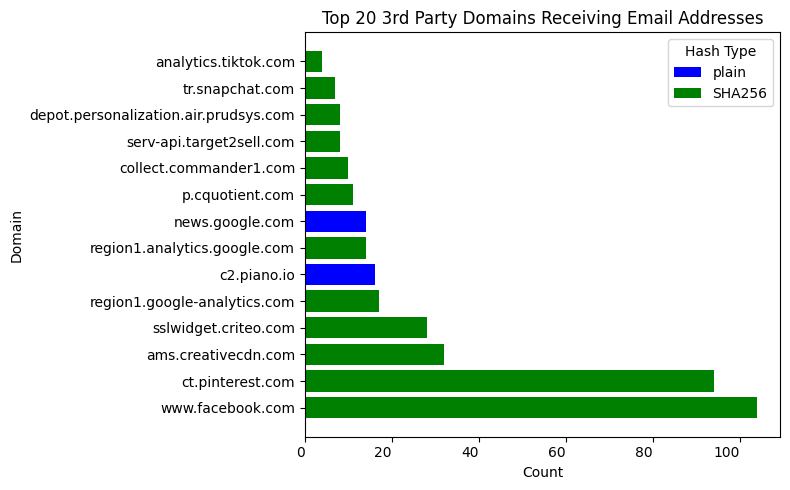

In [130]:
df = pd.DataFrame(results, columns=['Domain', 'Count', 'HashType'])

color_map = {
    'plain': 'blue',
    'SHA256': 'green'
}

# Map colors to hash types
df['Color'] = df['HashType'].map(color_map)

# Select top 20 domains
df_top20 = df.head(14)

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(df_top20['Domain'], df_top20['Count'], color=df_top20['Color'])
plt.title('Top 20 3rd Party Domains Receiving Email Addresses')
plt.xlabel('Count')
plt.ylabel('Domain')
plt.xticks(fontsize='medium', ha='right')
plt.tight_layout()

legend_elements = [Patch(facecolor=color_map[key], label=key) for key in color_map]
plt.legend(handles=legend_elements, title='Hash Type')

plt.show()


### Websites with most shared mail addresses

In [103]:
dbConnect = sqlite3.connect('third_party_analysis.db')
dbCursor = dbConnect.cursor()

query = "SELECT host, COUNT(*) FROM EmailHashes GROUP BY host ORDER BY COUNT(*) DESC"
dbCursor.execute(query)
results1 = dbCursor.fetchall()

for domain, count in results1:
    print(f"{count}\t{domain}")

dbConnect.close()

198	sephora.de
124	depot-online.de
24	telegraph.co.uk
14	uniqlo.com
8	thehindu.com
4	faz.net
2	merkur.de


**Visualization**

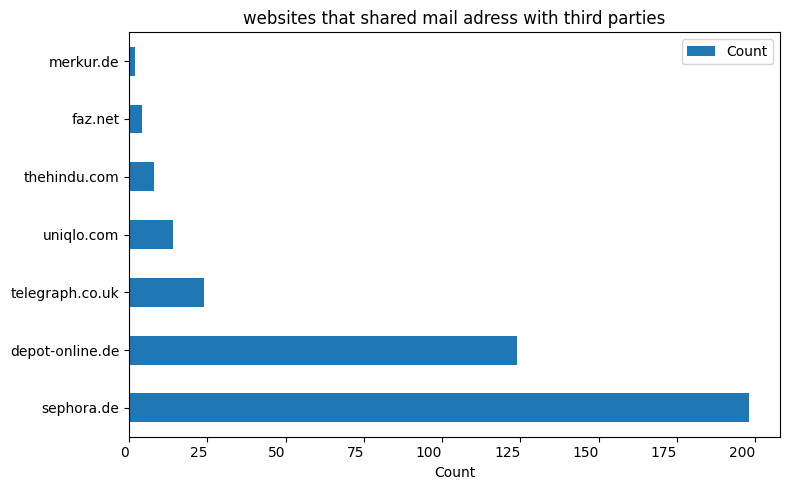

In [111]:
df = pd.DataFrame(results1, columns=['Host', 'Count'])

df_top20 = df.head(15)

df_top20.plot(kind='barh', x='Host', y='Count', figsize=(8, 5))

plt.title('websites that shared mail adress with third parties')
plt.xlabel('Count')
plt.ylabel('')

plt.xticks( fontsize='medium', ha='right')

plt.tight_layout()
plt.show()

### Example: Sephora

In [129]:
dbConnect = sqlite3.connect('third_party_analysis.db')
dbCursor = dbConnect.cursor()

query = "SELECT domain, COUNT(*) FROM EmailHashes WHERE host = 'sephora.de' GROUP BY domain ORDER BY COUNT(*) DESC"
dbCursor.execute(query)
results2 = dbCursor.fetchall()

for domain, count in results2:
    print(f"{count}\t{domain}")

dbConnect.close()

96	www.facebook.com
30	ct.pinterest.com
17	region1.google-analytics.com
14	region1.analytics.google.com
10	collect.commander1.com
8	sslwidget.criteo.com
8	serv-api.target2sell.com
7	tr.snapchat.com
5	p.cquotient.com
2	02179915.akstat.io
1	widget.eu.criteo.com


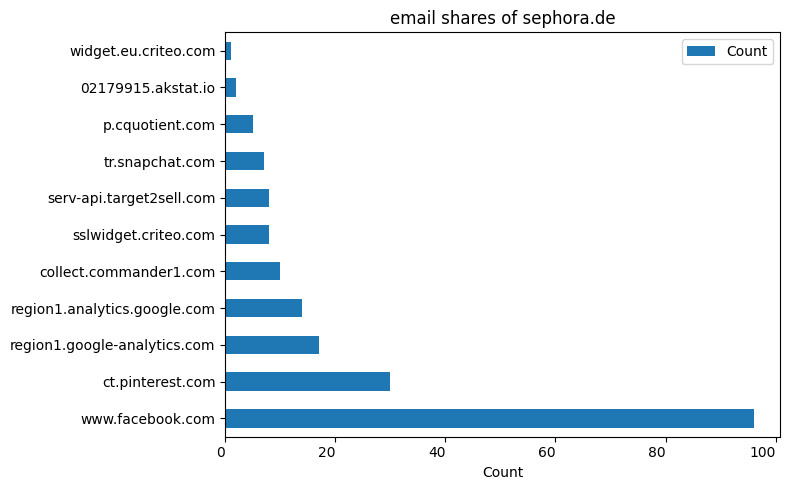

In [108]:
df = pd.DataFrame(results2, columns=['Domain', 'Count'])

df_top20 = df.head(25)

df_top20.plot(kind='barh', x='Domain', y='Count', figsize=(8, 5))

plt.title('email shares of sephora.de')
plt.xlabel('Count')
plt.ylabel('')

plt.xticks( fontsize='medium', ha='right')

plt.tight_layout()
plt.show()